# Testing functions for Gradient Plots

## Temperature

In [1]:
from xgcm import Grid
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from numba import jit

In [2]:
%matplotlib inline

In [3]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

In [5]:
# Load data
directory = '~/chazbpei2020/data/processed/Temp/RCP85/'
filename = 'temp_k01_ensAvg_1950_2100.nc'
temp_path = directory+filename
ds = xr.open_dataset(temp_path)

### Define some functions for calculating and organizing spatial distances between points in the model


In [6]:
@jit(nopython=True)
def haversine_distance(lat1,lat2,lon1,lon2,degrees=True):
    if degrees:
        fac = np.pi/180
        lat1 = lat1*fac
        lat2 = lat2*fac
        lon1 = lon1*fac
        lon2 = lon2*fac
    R = 6371E3
    return 2*R*np.arcsin(np.sqrt(np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin((lon2-lon1)/2)**2))

@jit(nopython=True)
def calc_spacing_from_latlon(lon_c,lon_g,lon_c_bnds,lon_g_bnds,lat_c,lat_g,lat_c_bnds,lat_g_bnds):
    ni = len(lon_c)
    nj = len(lat_c)
    dxC = np.zeros(shape=(ni,nj))
    dxG = np.zeros(shape=(ni,nj))
    dyC = np.zeros(shape=(ni,nj))
    dyG = np.zeros(shape=(ni,nj))
    for i in range(ni):
        for j in range(nj):
            dxC[i,j] = haversine_distance(lat_c[j],lat_c[j],lon_c_bnds[i,0],lon_c_bnds[i,1],degrees=True)
            dxG[i,j] = haversine_distance(lat_c[j],lat_c[j],lon_g_bnds[i,0],lon_g_bnds[i,1],degrees=True)
            
            dyC[i,j] = haversine_distance(lat_c_bnds[j,0],lat_c_bnds[j,1],lon_c[i],lon_c[i],degrees=True)
            dyG[i,j] = haversine_distance(lat_g_bnds[j,0],lat_g_bnds[j,1],lon_c[i],lon_c[i],degrees=True)
            
    return dxC,dxG,dyC,dyG

def into_arrays(dxC,dxG,dyC,dyG,lon_c,lon_g,lat_c,lat_g):
    dxC = xr.DataArray(dxC,dims=['XG','YC'],coords={'XG':lon_g,'YC':lat_c})
    dxC.name = 'dxC'
    dxG = xr.DataArray(dxG,dims=['XC','YG'],coords={'XC':lon_c,'YG':lat_g})
    dxG.name = 'dxG'
    dyC = xr.DataArray(dyC,dims=['XC','YG'],coords={'XC':lon_c,'YG':lat_g})
    dyC.name = 'dyC'
    dyG = xr.DataArray(dyG,dims=['XG','YC'],coords={'XG':lon_g,'YC':lat_c})
    dyG.name = 'dyG'
    return dxC,dxG,dyC,dyG

### Calculate distances between data points

In [19]:
# Calculate distances between datapoints
lon_c = ds['xt_ocean'].data
lon_c_bnds = ds['xt_ocean_bnds'].data
lon_g = lon_c-0.5
lon_g_bnds = lon_c_bnds-0.5
lat_c = ds['yt_ocean'].data
lat_c_bnds = ds['yt_ocean_bnds'].data
lat_g = lat_c-0.5
lat_g_bnds = lat_c_bnds-0.5

In [20]:
# Calcualte Cartesian distance between adj coordinates
dxC_vals,dxG_vals,dyC_vals,dyG_vals = calc_spacing_from_latlon(lon_c,lon_g,lon_c_bnds,lon_g_bnds,lat_c,lat_g,lat_c_bnds,lat_g_bnds)
# Convert to DataArray
dxC,dxG,dyC,dyG = into_arrays(dxC_vals,dxG_vals,dyC_vals,dyG_vals,lon_c,lon_g,lat_c,lat_g)

# Calculate gridcell areas
rA = xr.DataArray(dxC_vals*dyC_vals,dims=['XC','YC'],coords={'XC':lon_c,'YC':lat_c})
rA.name = 'rA'

### Build xgcm grid

In [21]:
# Build a new dataset with all of the grid information
ds_new = ds.copy()
ds_new = ds.rename({'xt_ocean':'XC','yt_ocean':'YC'}).assign_coords({'XG':lon_g,'YG':lat_g}).squeeze()
ds_new = xr.merge([ds_new,dxC,dxG,dyC,dyG,rA])

In [22]:
# Build the grid object
coords = {'X': {'center': 'XC', 'left': 'XG'}, 'Y': {'center': 'YC', 'left': 'YG'}}
grid = Grid(ds_new, periodic=['X'], coords=coords)
grid

<xgcm.Grid>
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center

In [24]:
ds_new

<xarray.Dataset>
Dimensions:        (XC: 360, XG: 360, YC: 180, YG: 180, bnds: 2, time: 1812)
Coordinates:
  * time           (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00
    st_ocean       float64 5.0
  * YC             (YC) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * XC             (XC) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * XG             (XG) float64 -0.75 0.25 1.25 2.25 ... 355.2 356.2 357.2 358.3
  * YG             (YG) float64 -90.75 -89.75 -88.75 ... 86.25 87.25 88.25
Dimensions without coordinates: bnds
Data variables:
    yt_ocean_bnds  (YC, bnds) float64 -90.0 -89.0 -89.0 -88.0 ... 89.0 89.0 90.0
    xt_ocean_bnds  (XC, bnds) float64 0.0 1.0 1.0 2.0 ... 359.0 359.0 360.0
    temp           (time, YC, XC) float32 ...
    dxC            (XG, YC) float64 970.3 2.911e+03 4.85e+03 ... 2.911e+03 970.3
    dxG            (XC, YG) float64 970.3 2.911e+03 4.85e+03 ... 2.911e+03 970.3
    dyC            (XC, YG) float64 1.112e+05 1.112e+05 ... 1.112e+05 1.112e+05
    dyG            (XG, YC) float64 1.112e+05 1.112e+05 ... 1.112e+05 1.112e+05
    rA             (XC, YC) float64 1.079e+08 3.237e+08 ... 3.237e+08 1.079e+08

### Calculate 2D spatial derivatives

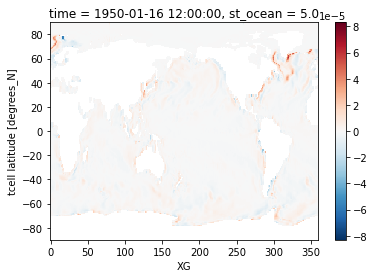

In [23]:
# Take the derivative with a simple difference calculation
# Derivative in the x-direction
dTdx = grid.diff(ds_new['temp'], 'X')/ds_new['dxC']
dTdx.isel(time=0).plot()

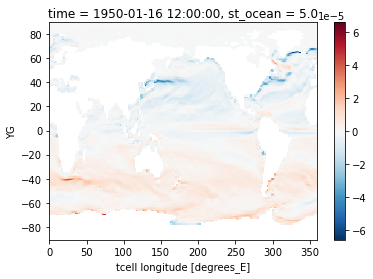

In [24]:
# Derivative in the y-direction
dTdy = grid.diff(ds_new['temp'],'Y',boundary='fill')/ds_new['dyC']
dTdy.isel(time=0).plot()